# DeiT fine-tuning analysis

Import all necessary libraries and modules

In [2]:
# TODO (later): retain only what's necessary

import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from models_v2 import *

Set global variables

In [3]:
RESULTS_DIR = "models/20_01_2025_21_10/"

LOG_PATH = RESULTS_DIR + "log.txt"
MODEL_PATH = RESULTS_DIR + "best_checkpoint.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#### Load log file

In [4]:
def read_log(log_path: str) -> pd.DataFrame:
    with open(log_path, "r") as f:
        lines = f.readlines()
    log_data = [json.loads(line) for line in lines]
    return pd.DataFrame(log_data)

In [5]:
read_log(LOG_PATH)

,train_lr,train_loss,test_loss,test_acc1,test_acc5,epoch,n_parameters
0,0.000001,5.034757,0.718526,82.548003,96.430002,0,4013416
1,0.000001,3.574236,0.734999,82.290003,96.260002,1,4013416
2,0.000101,2.344654,0.703127,81.652002,96.056003,2,4013416
3,0.000201,2.025807,0.717565,81.302003,95.946003,3,4013416
4,0.000300,1.938563,0.734037,80.796002,95.824003,4,4013416
5,0.000400,1.907937,0.744422,80.134002,95.716002,5,4013416
6,0.000255,1.824564,0.712913,80.968003,95.980003,6,4013416
7,0.000179,1.775066,0.695902,81.708003,96.076002,7,4013416
8,0.000111,1.732714,0.678040,82.004003,96.212003,8,4013416
9,0.000057,1.705318,0.668219,82.186002,96.272002,9,4013416


#### Load model

In [6]:
def load_model(model_path: str) -> nn.Module:
    model = torch.load(model_path, map_location=DEVICE)
    return model


In [7]:
model_dict = load_model(MODEL_PATH)

model = model_dict["model"]

C:\Users\agata\AppData\Local\Temp\ipykernel_20120\3290159885.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=DEVICE)


In [8]:
# instantiate a model with registers
ft_model = deit_small_patch16_LS_reg(pretrained=False, num_classes=1000)
# load a pretrained state dict containing register_tokens
ft_model.load_pretrained_state_dict(model_dict["model"])
ft_model = ft_model.to(DEVICE).eval()

>>>>>>>>>>>>>>>>>>>> NUMBER OF REGISTERS: 0
Loading 4 register tokens.


In [9]:
print("Registers shape: ", ft_model.register_tokens.shape, "\n")
print(ft_model)

Registers shape:  torch.Size([4, 384]) 

vit_models(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x Layer_scale_init_Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=T

## Initial visualization (TBD)

In [62]:
def show_artifacts(
    test_model: nn.Module, test_image: torch.Tensor, log_scale=False, token: int = 0, shape: tuple = (24, 24)
) -> None:
    """
    Generate the Attention maps and the norm values for the DEIT-III model

    test_model: DEIT-III model to be tested,
    test_image: Image of the correct size for the corresponding model, and batch dimension is accounted for
    log_scale: If True, the log of the attention map values will be displayed
    token: The token to be visualized in the attention maps
    """

    test_model(test_image)
    num_blocks = len(test_model.blocks)

    ## 1. Norm of feature values after MLP
    print("Norm of feature values after MLP")
    output = test_model.block_output[f"block{num_blocks-1}"]
    output = output.squeeze(0)
    # output = output[1:] # !!!!!!!!!!!
    # copmute norm of all output elements
    output_norms = output.norm(dim=-1)
    # output_norms.shape

    # TODO: double check
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    discard_tokens = 4 # discard the CLS token and 4 register tokens

    output_norms = output_norms[1:-discard_tokens]
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    plt.imshow(output_norms.reshape(shape[0], shape[1]).detach().numpy())
    plt.axis("off")
    plt.colorbar(label="Norm Values")  # add a colorbar as a legend
    plt.show()

    plt.hist(output_norms.detach().numpy(), bins=50)
    plt.xlabel("Norm Values")
    plt.ylabel("Frequency")
    plt.show()
    #########################################################################################################

    ## 2. Attention maps for the last Attention Head
    print("Attention maps for the last Attention Head")
    attn_map_mean = (
        test_model.blocks[num_blocks - 1].attn.attn_map.squeeze(0).mean(dim=0)
    )
    ### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    attn_map_mean = attn_map_mean[token][1:-discard_tokens]
    if log_scale:
        attn_map_mean = torch.log(attn_map_mean + 1e-6)
    # attn_map_mean.shape

    plt.imshow(attn_map_mean.reshape(shape[0], shape[1]).detach().numpy())
    plt.axis("off")
    plt.colorbar(label="CLS attention map")
    plt.show()
    #########################################################################################################

    ## 3. All attention maps
    print("All attention maps")

    num_cols = 6
    num_rows = (
        num_blocks + num_cols - 1
    ) // num_cols  # calculate the number of rows needed
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 2.5))
    axes = axes.flatten()

    for i in range(num_blocks):
        attn_map = test_model.blocks[i].attn.attn_map.squeeze(0).mean(dim=0)
        # attn_map = attn_map[token][1:] # !!!!!!!!!!!
        attn_map = attn_map[token][1:-discard_tokens]
        attn_map_img = attn_map.reshape(shape[0], shape[1]).detach().numpy()

        axes[i].imshow(attn_map_img)
        axes[i].axis("off")
        axes[i].set_title(f"Block {i+1}")

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

    #########################################################################################################

In [63]:
def get_image(image_path: str, img_shape: tuple = (384, 384)) -> torch.Tensor:
    """Load an image, resize, normalize, and convert to a tensor with a batch dimension."""
    img = Image.open(image_path).convert("RGB")
    img = img.resize(img_shape)
    img = np.array(img).transpose(2, 0, 1)  # convert to numpy and rearrange dimensions
    img = (
        torch.tensor(img, dtype=torch.float32) / 255.0
    )  # normalize and convert to tensor
    return img.unsqueeze(0)  # Add batch dimension


def plot_image(image_tensor: torch.Tensor) -> None:
    """Plot a single image tensor."""
    image_np = (
        image_tensor.permute(1, 2, 0).clip(0, 1).numpy()
    )  # Convert to (H, W, C) and clip values
    plt.imshow(image_np)
    plt.axis("off")
    plt.show()

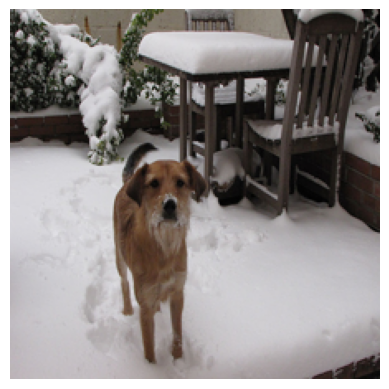

In [64]:
image_path = "./images/dog.JPEG"
img = get_image(image_path, img_shape=(224, 224)) # resize to 224x224!
plot_image(img.squeeze(0))

In [65]:
# final output shape
ft_model(img).shape

torch.Size([1, 1000])

Norm of feature values after MLP


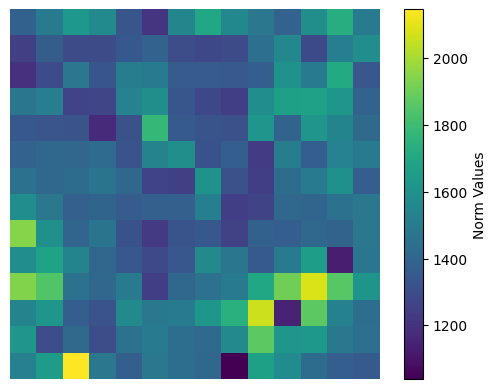

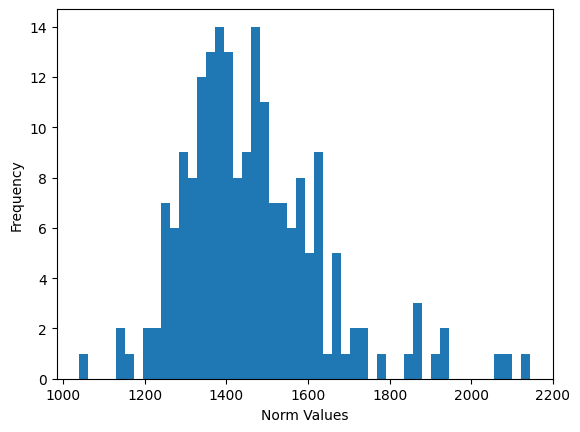

Attention maps for the last Attention Head


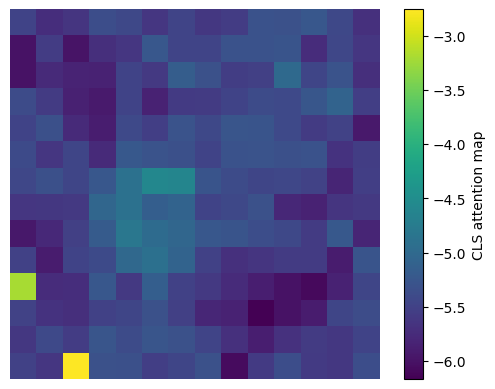

All attention maps


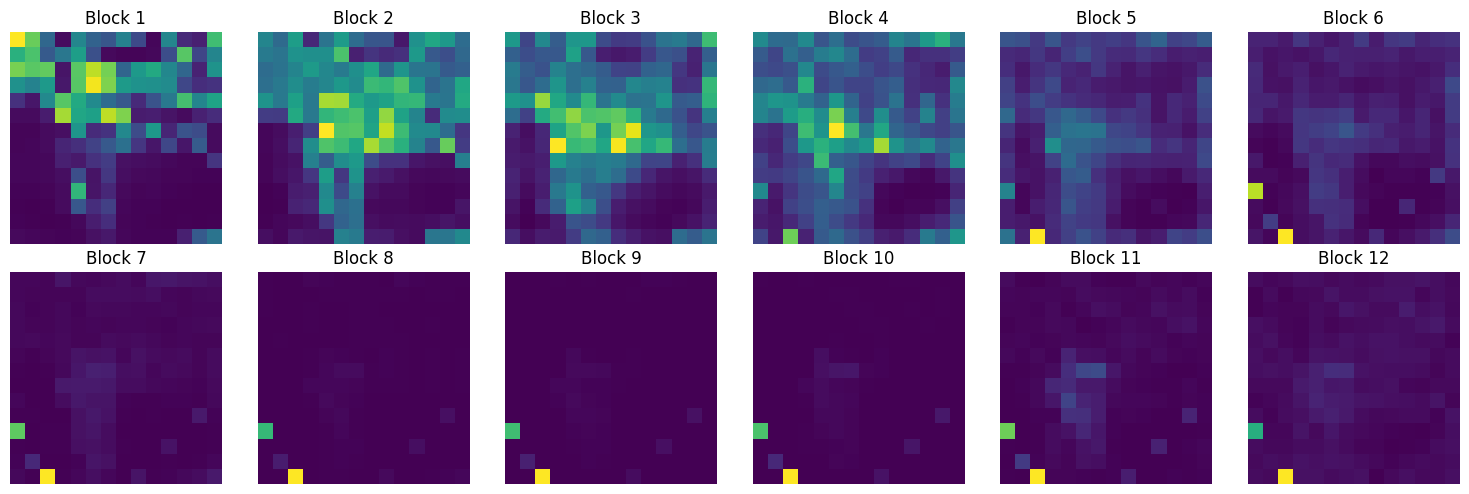

In [66]:
show_artifacts(ft_model, img, log_scale=True, token=0, shape=(14, 14))